# Two-step estimation: MLE + Non-linear least squares

#### Balint Szoke

#### September 2017

> This notebook implements the two-step procedure of Section 3.4. of the paper. The first step constitutes the estimation of the baseline model with maximum likelihood. Taking these parameters as given, the second step is to estimate the parameters of the tilting function using data on zero-coupon yields.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from robust import *
from robust_utils import *

sb.set_style('white')
sb.set_style("ticks")

## Loading the grand dataset

`data/data.csv` contains all the time series we need other than the survey data

In [2]:
data = pd.read_csv('../data/data.csv', sep=',', index_col=0)
data.index = pd.date_range(data.index[0], data.index[-1], freq='Q')

Alternative periods
  * $1952: Q2 - 2016:Q4$ -- when the CRSP yield data starts
  * $1961: Q2 -$ present -- when the GSW yield data starts
  * $1982: Q2 -$ present -- when the Blue-Chip survey data starts
  * $1952: Q2 - 2005:Q4$ -- Piazzesi and Schneider's sample period
  
Two sources of zero coupon yields: 
    * CRSP: risk-free rate + from year1 to year 5 (from 1952:Q2)
    * GSW: - from year1 to year7 (from 1961:Q2 - present) 
           - from year8 to year15 (from 1971:Q4 - present) 
           - from year16 to year20 (from 1981:Q3 - present)
           - from year21 to year30 (from 1985:Q4 - present)

In [3]:
update_figures = True

#----------------------------------------------
# Specify the relevant time period
#----------------------------------------------
start_date = '1952-06-30'
end_date =  '2017-06-30'

data = data[start_date:end_date]

#----------------------------------------------
# Specify the subset of used variables
#----------------------------------------------
aggregate_vars = ['dc', 'pi']
gsw_vars = ['SVENY01','SVENY05', 'SVENY10', 'SVENY15', 'TIPSY05', 'TIPSY15']
YTM_N = [4, 20, 40, 60]                     # maturity in Q for the nominal yields
YTM_R = [20, 60]                            # maturity in Q for the TIPS yields (if none, set YTM_R = [])
YTM = {'nominal' : YTM_N, 'real' : YTM_R}

#----------------------------------------------
# Some objects that help plotting
#----------------------------------------------
gsw_plot = ['SVENY0{:d}'.format(i) for i in range(1,10)] + ['SVENY{:d}'.format(i) for i in range(10, 16)]
separating_dates = ['1999-01-01', '1971-12-01']

first_survey_index = (pd.Timestamp('1989-10-30') < data.index).tolist().index(1)

---------------------------------------------------------------------

## Step 1: MLE for the baseline model

Initial values for the optimization 

In [4]:
N, M, K = 2, 2, 2
delta = .0002

kappa_D0 = np.asarray([[0.722, -0.032], 
                       [0.119,  0.952]])
sigma_D0 = np.asarray([[0.152, -0.021], 
                       [0.001,  0.176]])
alpha_D0 = np.asarray([[0.418,  0.000], 
                       [-0.076, 0.355]])
beta0_D0 = np.asarray([[0.755], 
                       [0.856]])
phi_D0 = np.zeros((N, 1))
beta1_D0 = np.eye(M)

param_D0 = build_params(phi_D0, kappa_D0, sigma_D0, beta0_D0, beta1_D0, alpha_D0)

Do we include $\beta_0$ (unconditional means) in the MLE, or estimate it separately by the sample mean?
* when `specification = "restricted_2"`: the function does include $\beta_0$ and so the estimates are MLE
* when `specification = "restricted_3"`: $\beta_0$ are estimated by the sample means

In [5]:
specification = "restricted_3"

# ==============================================
# Initial condition for the numerical optimizer
# ==============================================
if specification == "restricted_2":
    paramD_init = np.hstack([param_D0[2:12], param_D0[16], param_D0[18], param_D0[19]])
elif specification == "restricted_3":
    paramD_init = np.hstack([param_D0[2:10], param_D0[16], param_D0[18], param_D0[19]])

MLE estimation of the parameters

In [6]:
step1_est, step1_est_se, result_step1 = first_step_estimation(data[aggregate_vars], paramD_init, specification)

Optimization terminated successfully.
         Current function value: 0.916535
         Iterations: 14
         Function evaluations: 286
         Gradient evaluations: 22


L_1 and L_inf norm of the gradient vector at MLE:
   ||x||_1 = 0.00000      ||x||_inf=0.00000
Hessian negative definite at MLE?:
True


Parameter estimates:
[ 0.     0.     0.703 -0.026  0.137  0.947  0.154 -0.02  -0.001  0.178
  0.472  0.847  1.     0.     0.     1.     0.417  0.    -0.081  0.351]
Asymptotic standard errors:
[ 0.     0.     0.084  0.034  0.072  0.028  0.026  0.025  0.024  0.026  0.
  0.     0.     0.     0.     0.     0.018  0.     0.022  0.015]


In [7]:
##=================================================
## Generate latex table
##=================================================

def format_table(x):
    if type(x) == float:
        return '{0:.3f}'.format(x)
    if type(x) == str:
        return '{0:.5s}'.format(x)

def format_table_par(x):
    if type(x) == float:
        return '({0:.3f})'.format(x)
    if type(x) == str:
        return '{0:.5s}'.format(x)
    
table1 = extract_params(step1_est)
empty_cell = np.ones((2, 1))
coeffs = np.hstack([table1[1], empty_cell, table1[2], empty_cell, table1[3], empty_cell, table1[5]])
table1 = extract_params(step1_est_se)
coeffs_se = np.hstack([table1[1], empty_cell, table1[2], empty_cell, table1[3], empty_cell, table1[5]])

table1 = np.vstack([coeffs[0, :], coeffs_se[0, :], coeffs[1, :], coeffs_se[1, :]]) 

table1 = np.asarray(table1, dtype='object')

table1[:, 2] = np.asarray(["", "", "", ""])
table1[:, 5] = np.asarray(["", "", "", ""])
table1[:, 7] = np.asarray(["", "", "", ""])

table1[[1, 3], 6] = np.asarray(["-", "-"])
table1[1, -1] = "-"

print(" \\\\\n".join([" & ".join(map(format_table, table1[0, :]))]) + "\\\\\n" +
      " \\\\\n".join([" & ".join(map(format_table_par, table1[1, :]))]) + "\\\\\n" + 
      " \\\\\n".join([" & ".join(map(format_table, table1[2, :]))]) + "\\\\\n" + 
      " \\\\\n".join([" & ".join(map(format_table_par, table1[3, :]))]))

0.703 & -0.026 &  & 0.154 & -0.020 &  & 0.472 &  & 0.417 & 0.000\\
(0.084) & (0.034) &  & (0.026) & (0.025) &  & - &  & (0.018) & -\\
0.137 & 0.947 &  & -0.001 & 0.178 &  & 0.847 &  & -0.081 & 0.351\\
(0.072) & (0.028) &  & (0.024) & (0.026) &  & - &  & (0.022) & (0.015)


Turn the estimated parameters into the form that the `Robust` class can handle (estimation was done with growth rates in percentage, but $d\log C$ is percentege/100, so we need to divide the system by $100$) 

In [8]:
phi_D, kappa_D, sigma_D, beta0_D, beta1_D, alpha_D = extract_params(step1_est) 
#X_hat = kalman_filter(result_step1.x, data[aggregate_vars], model = specification)[1].T
X_hat = kalman_smoother(result_step1.x, data[aggregate_vars], model = specification)[0].T
beta0_D, alpha_D, phi_D, sigma_D = beta0_D/100, alpha_D/100, phi_D/100, sigma_D/100
X_hat = X_hat/100

#If we want to use the exact continuous-time parameters use this line
phi_est, kappa_est, sigma_est, beta0_est, beta1_est, alpha_est = from_discrete_to_cont(phi_D, kappa_D, sigma_D, 
                                                                                       beta0_D, beta1_D, alpha_D)

#If the assumption is that the estimated models are the continuous time parameters use
#phi_est, kappa_est, sigma_est = phi_D, np.eye(2) - kappa_D, sigma_D 
#beta0_est, beta1_est, alpha_est = beta0_D, beta1_D, alpha_D

param_est_cont = build_params(phi_est, kappa_est, sigma_est, beta0_est, beta1_est, alpha_est)

Plot the yield data with the filtered state variables

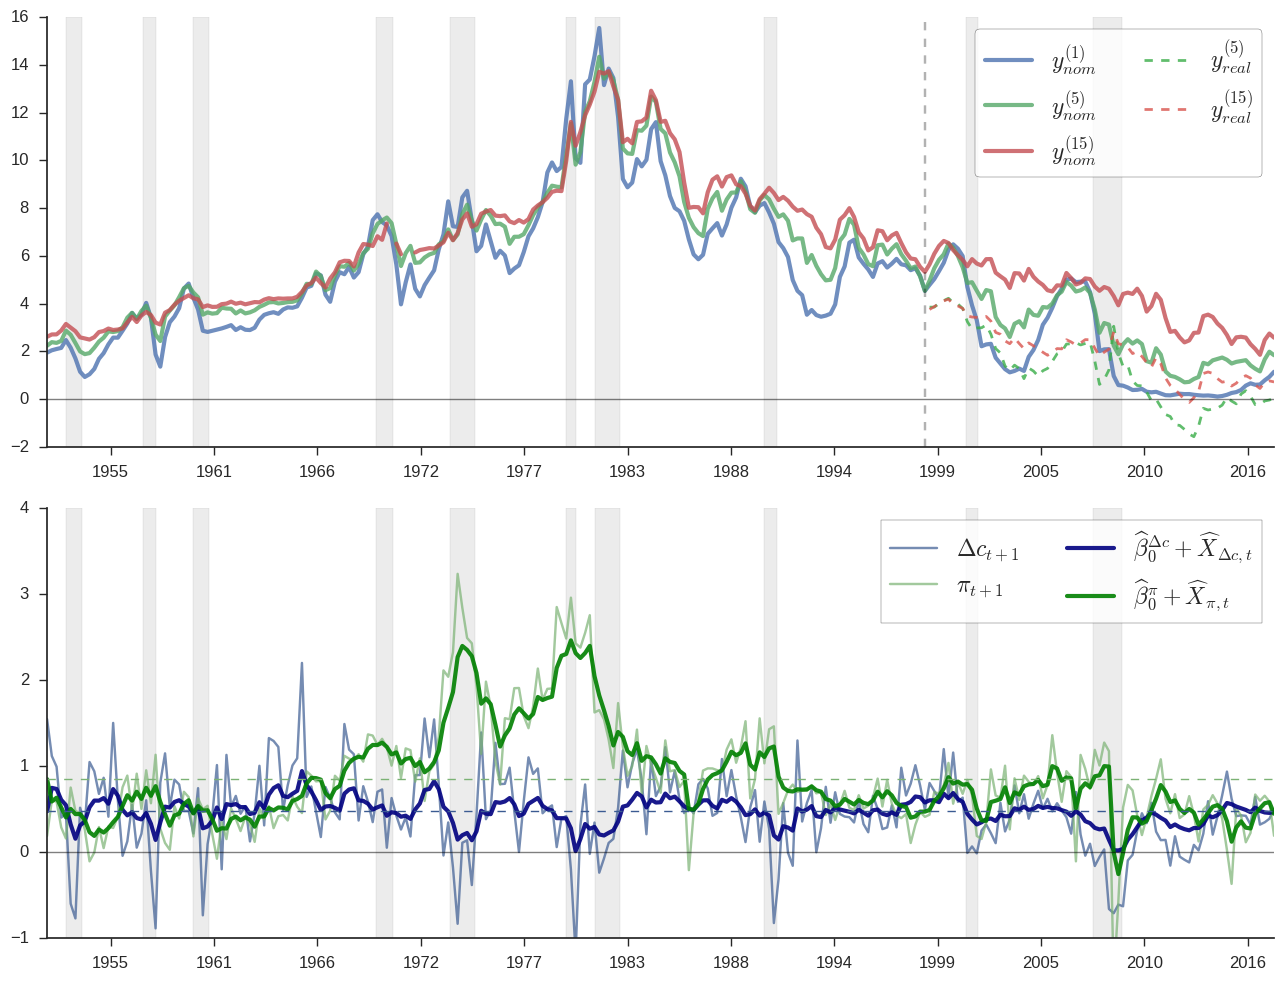

In [9]:
fig, ax = plt.subplots(2,1, figsize = (13, 10))
sb.despine()
ax[0].plot(data[['SVENY01', 'SVENY05', 'SVENY15']], lw = 3, alpha=.8)
ax[0].plot(data[['TIPSY05']], lw = 2, linestyle = '--', color = sb.xkcd_rgb['medium green'], alpha=.8)
ax[0].plot(data[['TIPSY15']], lw = 2, linestyle = '--', color = sb.xkcd_rgb['pale red'], alpha=.8)
ax[0].axhline(linewidth = 1, color = 'k', alpha=.5)

ax[0].legend(['$y^{(1)}_{nom}$', '$y^{(5)}_{nom}$', '$y^{(15)}_{nom}$', 
              '$y^{(5)}_{real}$', '$y_{real}^{(15)}$' ], fontsize = 17, loc='best', ncol = 2, 
             fancybox = True, frameon=True, framealpha=0.8)
ax[0].tick_params(axis='both', which='major', labelsize = 12)
ax[0].axvline(separating_dates[0], linestyle = '--', color = 'k', alpha = .3)
ax[0].set_xlim([start_date, end_date])
max_yticks = 15
xloc = plt.MaxNLocator(max_yticks)
ax[0].xaxis.set_major_locator(xloc)
NBER_Shade(ax[0], start_date, '../data/from_web/NBER_dates.txt')

d = {'pi': 100*(X_hat[:, 1] + beta0_est[1]),
     'dc': 100*(X_hat[:, 0] + beta0_est[0])}
ax[1].plot(data[aggregate_vars]['dc'], color = sb.xkcd_rgb["denim blue"], alpha = .7)
ax[1].plot(data[aggregate_vars]['pi'], color = sb.xkcd_rgb["faded green"], alpha = .7)
ax[1].plot(pd.DataFrame(data=d, index = data.index)['dc'], lw=3, color = '#000080', alpha = .9)
ax[1].plot(pd.DataFrame(data=d, index = data.index)['pi'], lw=3, color = '#008000', alpha = .9)
ax[1].axhline(linewidth = 1, color = 'k', alpha=.5)
ax[1].axhline(100*beta0_est[1], lw = 1, color = sb.xkcd_rgb["faded green"], linestyle = '--')
ax[1].axhline(100*beta0_est[0], lw = 1, color = sb.xkcd_rgb["denim blue"], linestyle = '--')
ax[1].set_ylim([-1, 4])
ax[1].legend(['$\Delta c_{t+1}$', '$\pi_{t+1}$', r'$\widehat \beta^{\Delta c}_0 + \widehat{X}_{\Delta c, t}$', 
              r'$\widehat \beta^{\pi}_0 + \widehat{X}_{\pi, t}$'],
             loc='best', fontsize = 17, ncol = 2, frameon=True, framealpha=0.8)
ax[1].set_xlim([start_date, end_date])
ax[1].tick_params(axis='both', which='major', labelsize = 12)
ax[1].xaxis.set_major_locator(xloc)
NBER_Shade(ax[1], start_date, '../data/from_web/NBER_dates.txt')

plt.tight_layout()
if update_figures:
    plt.savefig("../figures/fig1.pdf")

------------------------------------------------------------------------------------------

## Step 2: Minimized squared error for the parameters of the tilting function

I will consider two restictions on the $\Xi$ matrix

$$\Xi = \left[\begin{matrix} x_0 & 0 & 0 \\ 0 & x_1 & x_2 \\ 0 & x_2 & x_3  \end{matrix} \right]$$

 * **Case 1:** estimate all parameters $(x_0, x_1, x_2, x_3)$ with the only restriction that $\Xi$ is positive semi-definite

 * **Case 2:** impose the restriction that $x_1=x_2=x_3=0$ and estimate only $x_0\geq 0$. (standard muliplier preference model

 * **Case 3:** impose that restriction that $x_0 = 0$ and estimate only the remaining $(x_1, x_2, x_3)$ so that $\Xi$ is positive semi-definite

### Estimate all parameters $(x_0, x_1, x_2, x_3)$

In [10]:
# Specify the constraints necessary to guarantee positive semi-definiteness
case = 1
cons = ({'type': 'ineq',
         'fun' : lambda x: np.array([x[1]*x[3] - x[2]*x[2]]),
         'jac' : lambda x: np.array([0, x[3], -2*x[2], x[1]])})
bound = ((0, None), (0, None), (None, None), (0, None))

print('Value of the objective function witout xi')
print(second_step_estimation(np.zeros(4), param_est_cont, X_hat, data[gsw_vars], YTM, case=case, delta=delta)[0])

if specification == 'restricted_2':
    param_xi_0 = np.asarray([.01, 61, -700, 1000])           # delta = 0.001
    #param_xi_0 = np.asarray([.001, 51, -790, 1000])          # delta = 0.0025
elif specification == 'restricted_3':
    param_xi_0 = np.asarray([.001, 800, -800, 1100])
    param_xi_0 = np.asarray([.01, 900, -800, 1140])
#   param_xi_0 = np.asarray([.01, 50, -70, 100])            # sample ends in 2005 Q4

res_step2_case1 = sp.optimize.minimize(lambda x: second_step_estimation(x, param_est_cont, 
                                                                        X_hat, data[gsw_vars], 
                                                                        ytm=YTM, case=case, 
                                                                        delta=delta)[0],
                                 param_xi_0,
                                 constraints = cons, bounds = bound, 
                                 method = 'SLSQP', options={'maxiter': 1000, 'ftol' : 1e-10, 'disp': True})
print(res_step2_case1)

Value of the objective function witout xi
508.496935619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 382.7833142442854
            Iterations: 13
            Function evaluations: 190
            Gradient evaluations: 13
     fun: 382.7833142442854
     jac: array([ 179.99310684,   32.78785324,  115.59807205,   24.96067047])
 message: 'Optimization terminated successfully.'
    nfev: 190
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([  2.10693657e-11,   8.99799745e+02,  -7.99042620e+02,
         1.13863608e+03])


In [11]:
# delta=0.001
# [  1.00000000e-02   6.10000000e+01  -7.00000000e+02   1.00000000e+03]
#      fun: 386.6054932491165
#      jac: array([  0.63139343, -46.33163071, -20.53295517, -35.28048325])
#  message: 'Optimization terminated successfully.'
#     nfev: 146
#      nit: 13
#     njev: 13
#   status: 0
#  success: True
#        x: array([  8.97328417e-02,   2.50058313e+02,  -4.47602414e+02,
#          1.02520459e+03])

In [12]:
# # if delta = 0.0025
# opti(np.asarray([0.009, 61, -700, 1130]))

### Standard multiplier preference 

In [13]:
# Specify the constraints necessary to guarantee positive semi-definiteness
bound = [(0, None)]

print('Value of the objective function witout xi')
print(second_step_estimation(np.zeros(1), param_est_cont, X_hat, data[gsw_vars], ytm=YTM, case=2, delta=delta)[0])
print('')

if specification == 'restricted_2':
    param_xi_0 = np.asarray([1])
elif specification == 'restricted_3':
    param_xi_0 = np.asarray([1])


res_step2_case2 = sp.optimize.minimize(lambda x: second_step_estimation(x, param_est_cont, 
                                                                        X_hat, data[gsw_vars], 
                                                                        ytm=YTM, case=2, 
                                                                        delta=delta)[0],
                                 param_xi_0,
                                 bounds = bound, 
                                 method = 'SLSQP', options={'maxiter': 1000, 'ftol' : 1e-10, 'disp': True})
print(res_step2_case2)

Value of the objective function witout xi
508.496935619

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 508.4969356193621
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 2
     fun: 508.4969356193621
     jac: array([ 1214172.65191269])
 message: 'Positive directional derivative for linesearch'
    nfev: 6
     nit: 6
    njev: 2
  status: 8
 success: False
       x: array([ 0.])


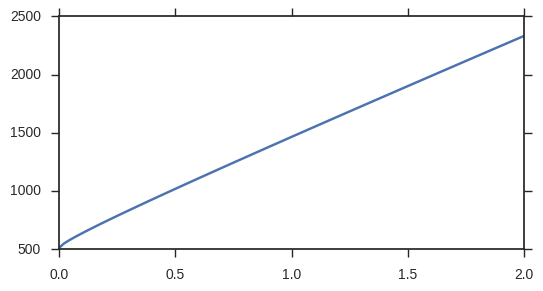

In [14]:
def multiplier_pref(x):
    x = np.asarray([x])
    return second_step_estimation(x, param_est_cont, X_hat, data[gsw_vars], ytm=YTM, case=2, delta=delta)[0]

x_grid = np.linspace(0, 2, 100)
y_grid = np.asarray(list(map(multiplier_pref, x_grid)))

fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(x_grid, y_grid)

What would be the estimated $\gamma$ in the recursive utility model?

$$(\gamma-1)= \frac{1}{\ell^{*}(\xi_0)} = \sqrt{\frac{\xi_0\delta^2}{\left|\alpha' e_1 + \sigma'\left(\delta I_2 + \kappa'\right)^{-1}\beta_1'e_1\right|^2}}$$

In [15]:
denom = alpha_est.T[:,0] + sigma_est.T @ np.linalg.inv(delta*np.eye(2) + kappa_est.T) @ beta1_est.T[:, 0]
gg = (np.sqrt(res_step2_case2.x*delta**2 / (denom @ denom)) + 1)[0]
print('estimated gamma = {:1.3f}'.format(gg))
print('with beta = {:1.3f}'.format(np.exp(-4*delta)))

estimated gamma = 1.000
with beta = 0.999


### Estimate only $(x_1, x_2, x_3)$

In [16]:
# Specify the constraints necessary to guarantee positive semi-definiteness
case = 3
cons = ({'type': 'ineq',
         'fun' : lambda x: np.array([x[0]*x[2] - x[1]*x[1]]),
         'jac' : lambda x: np.array([x[2], -2*x[1], x[0]])})
bound = ((0, None), (None, None), (0, None))

print('Value of the objective function witout xi')
print(second_step_estimation(np.zeros(3), param_est_cont, X_hat, data[gsw_vars], YTM, case=case, delta=delta)[0])

if specification == 'restricted_2':
    param_xi_0 = np.asarray([50, -900, 1000])       # delta = 0.0025
    #param_xi_0 = np.asarray([60, -700, 1000])       # delta = 0.001
elif specification == 'restricted_3':
#    param_xi_0 = np.asarray([868.382173  ,  -812.32391074,  1132.11193897])
    param_xi_0 = np.asarray([960, -800, 1130])

#    param_xi_0 = np.asarray([100, -70, 100])       # is sample ends in 2005 Q4

res_step2_case3 = sp.optimize.minimize(lambda x: second_step_estimation(x, param_est_cont, 
                                                                        X_hat, data[gsw_vars], 
                                                                        ytm=YTM, case=case, 
                                                                        delta=delta)[0],
                                 param_xi_0,
                                 constraints = cons, bounds = bound, 
                                 method = 'SLSQP', options={'maxiter': 1000, 'ftol' : 1e-8, 'disp': True})
print(res_step2_case3)

Value of the objective function witout xi
508.496935619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 383.0861990751408
            Iterations: 10
            Function evaluations: 140
            Gradient evaluations: 10
     fun: 383.0861990751408
     jac: array([  64.4712944 ,  -36.39330292,  117.44678116])
 message: 'Optimization terminated successfully.'
    nfev: 140
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([  959.90732325,  -799.64677878,  1130.04654453])


#### Compare the three cases

In [17]:
print('Case1: ')
print('   fun:', res_step2_case1.fun)
print('     x:', res_step2_case1.x)
print('Case2: ')
print('   fun:', res_step2_case2.fun)
print('     x:', res_step2_case2.x)
print('Case3: ')
print('   fun:', res_step2_case3.fun)
print('     x:', res_step2_case3.x)

Case1: 
   fun: 382.7833142442854
     x: [  2.10693657e-11   8.99799745e+02  -7.99042620e+02   1.13863608e+03]
Case2: 
   fun: 508.4969356193621
     x: [ 0.]
Case3: 
   fun: 383.0861990751408
     x: [  959.90732325  -799.64677878  1130.04654453]


------------------
We should get something very similar to Case 1 from running BFGS. For this, we first reparametrize the $\Xi$ matrix (so that it is always positive definite) 

In [18]:
param_xi_0 = np.asarray([0.001, 30.5, -31.5, 0.01])
#param_xi_0 = np.asarray([.0, 12.1, -36.5, .095])
#param_xi_0 = np.asarray([.01, 24.14, -19.0, 0.01])
res_step2_C5 = sp.optimize.minimize(lambda x: ssq_error(x, param_est_cont, X_hat, data[gsw_vars], 
                                                        ytm = YTM, delta = delta, case = 5)[0],
                                    param_xi_0,
                                    method = 'BFGS',
                                    options = {'maxiter': 5000, 'gtol' : 1e-10, 'disp': True} )
print(res_step2_C5)
XX_C5 = make_Xi(xi_restrictions(res_step2_C5.x, 5))
print(XX_C5)

         Current function value: 4.163486
         Iterations: 2
         Function evaluations: 227
         Gradient evaluations: 36
      fun: 4.163485741286981
 hess_inv: array([[  1.00036152e+00,   1.63754140e-03,  -5.37305714e-04,
         -1.68743071e-04],
       [  1.63754140e-03,   9.01634609e-01,  -2.95849168e-01,
         -9.29614667e-02],
       [ -5.37305714e-04,  -2.95849168e-01,   9.70756290e-02,
          3.05030011e-02],
       [ -1.68743071e-04,  -9.29614667e-02,   3.05030011e-02,
          9.58464336e-03]])
      jac: array([-0.00780606,  0.04521108,  0.2214914 ,  0.117118  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 227
      nit: 2
     njev: 36
   status: 2
  success: False
        x: array([  1.00000042e-03,   3.05000000e+01,  -3.15000000e+01,
         9.99999080e-03])
[[  1.00000083e-06   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.30250000e+02  -9.60750000e+02]
 [  0.00000000e+00  -9.60750000e+02   9.92250

In [19]:
XX = np.asarray([[0.0, 0.0, 0.0],
                 [0.0, res_step2_case3.x[0], res_step2_case3.x[1]],
                 [0.0, res_step2_case3.x[1], res_step2_case3.x[2]]])

XX

array([[    0.        ,     0.        ,     0.        ],
       [    0.        ,   959.90732325,  -799.64677878],
       [    0.        ,  -799.64677878,  1130.04654453]])

In [20]:
np.linalg.cholesky(XX[1:, 1:])

array([[ 30.98237117,   0.        ],
       [-25.80973465,  21.53843406]])

In [21]:
np.linalg.eig(XX)

(array([ 1849.13600365,   240.81786413,     0.        ]),
 array([[ 0.        ,  0.        ,  1.        ],
        [-0.66866021,  0.7435681 ,  0.        ],
        [ 0.7435681 ,  0.66866021,  0.        ]]))

In [22]:
xi_0 = XX[0, 0]
xi_1 = np.asarray([[XX[1, 0]], [XX[2, 0]]])
xi_2 = np.asarray([[XX[1, 1], 0.0], [2*XX[2, 1], XX[2, 2]] ])

param_xi = np.asarray([XX[0, 0], XX[1, 0], XX[2, 0], XX[1, 1], 2*XX[2, 1], XX[2, 2]])

model2 = Robust(phi_est, kappa_est, sigma_est, beta0_est, beta1_est, alpha_est, xi_0, xi_1, xi_2, delta)

In [23]:
model2.print_out_params(discrete=1)

Baseline parameter values arising from discrete sampling
----------------------------------------------------------------------

phi   = [ 0.000]    kappa = [ 0.703, -0.026]    sigma = [ 0.156,  0.000]
        [ 0.000]            [ 0.137,  0.947]            [-0.023,  0.177]


beta0 = [ 0.472]    beta1 = [ 1.000, -0.000]    alpha = [ 0.417,  0.000]
        [ 0.847]            [ 0.000,  1.000]            [-0.081,  0.351]


Worst-case parameters arising from discrete sampling
----------------------------------------------------------------------

phi   = [-0.020]    kappa = [ 0.711, -0.020]    sigma = [ 0.156,  0.000]
        [ 0.024]            [ 0.155,  0.999]            [-0.022,  0.181]


beta0 = [ 0.405]    beta1 = [ 1.027,  0.021]    alpha = [ 0.417,  0.000]
        [ 0.915]            [ 0.041,  1.127]            [-0.081,  0.351]


In [24]:
##=================================================
## Generate latex table
##=================================================

def format_table(x):
    if type(x) == float:
        return '{0:.2f}'.format(x)
    if type(x) == str:
        return '{0:.5s}'.format(x)

empty_cell = np.ones((2, 1))
table3 = model2.from_cont_to_discrete()
coeffs = np.hstack([table3[0]*100, empty_cell, table3[1], empty_cell, table3[3]*100, empty_cell, table3[4]])
table3 = model2.from_cont_to_discrete(worstcase=1)
coeffs_tilde = np.hstack([table3[0]*100, empty_cell, table3[1], empty_cell, table3[3]*100, empty_cell, table3[4]])

table3 = np.asarray(np.vstack([coeffs, coeffs_tilde]), dtype='object')

table3[:, 1] = np.asarray(["", "", "", ""])
table3[:, 4] = np.asarray(["", "", "", ""])
table3[:, 6] = np.asarray(["", "", "", ""])

print(" \\\\\n".join([" & ".join(map(format_table, table3[0, :]))]) + "\\\\\n" +
      " \\\\\n".join([" & ".join(map(format_table, table3[1, :]))]) + "\\\\\n" + 
      " \\\\\n".join([" & ".join(map(format_table, table3[2, :]))]) + "\\\\\n" +
      " \\\\\n".join([" & ".join(map(format_table, table3[3, :]))]) + "\\\\\n") 



0.00 &  & 0.70 & -0.03 &  & 0.47 &  & 1.00 & -0.00\\
0.00 &  & 0.14 & 0.95 &  & 0.85 &  & 0.00 & 1.00\\
-0.02 &  & 0.71 & -0.02 &  & 0.41 &  & 1.03 & 0.02\\
0.02 &  & 0.15 & 1.00 &  & 0.92 &  & 0.04 & 1.13\\



## Analysis

In [25]:
yield_coeffs = model2.zero_coupon_yields(YTM['nominal'], worstcase = 1).T 
yield_coeffs_real = model2.zero_coupon_yields(YTM['real'], worstcase = 1, real = 1).T   

Xhat = np.ones((3, X_hat.shape[0]))
Xhat[1:,:] = X_hat.T

yield_hat = yield_coeffs @ Xhat            # Obs x T matrix containing the model implied yields
yield_hat[yield_hat < 0] = 0
yield_hat_R = yield_coeffs_real @ Xhat     # Obs x T matrix containing the model implied yields

yield_hat = np.vstack([yield_hat, yield_hat_R])

In [26]:
model_implied_5_1 = (yield_hat[1, :].T - yield_hat[0, :].T)
data_implied_5_1 = np.asarray(data['SVENY05'] - data['SVENY01'])

model_implied_10_1 = (yield_hat[2, :].T - yield_hat[0, :].T)
data_implied_10_1 = np.asarray(data['SVENY10'] - data['SVENY01'])

aux_df = pd.DataFrame(data = {'model_5_1' : model_implied_5_1, 'data_5_1' : data_implied_5_1, 
                              'model_10_1' : model_implied_10_1, 'data_10_1' : data_implied_10_1})
zx = aux_df.corr()
zx

,data_10_1,data_5_1,model_10_1,model_5_1
data_10_1,1.000000,0.962961,0.503808,0.482253
data_5_1,0.962961,1.000000,0.431312,0.399497
model_10_1,0.503808,0.431312,1.000000,0.979240
model_5_1,0.482253,0.399497,0.979240,1.000000


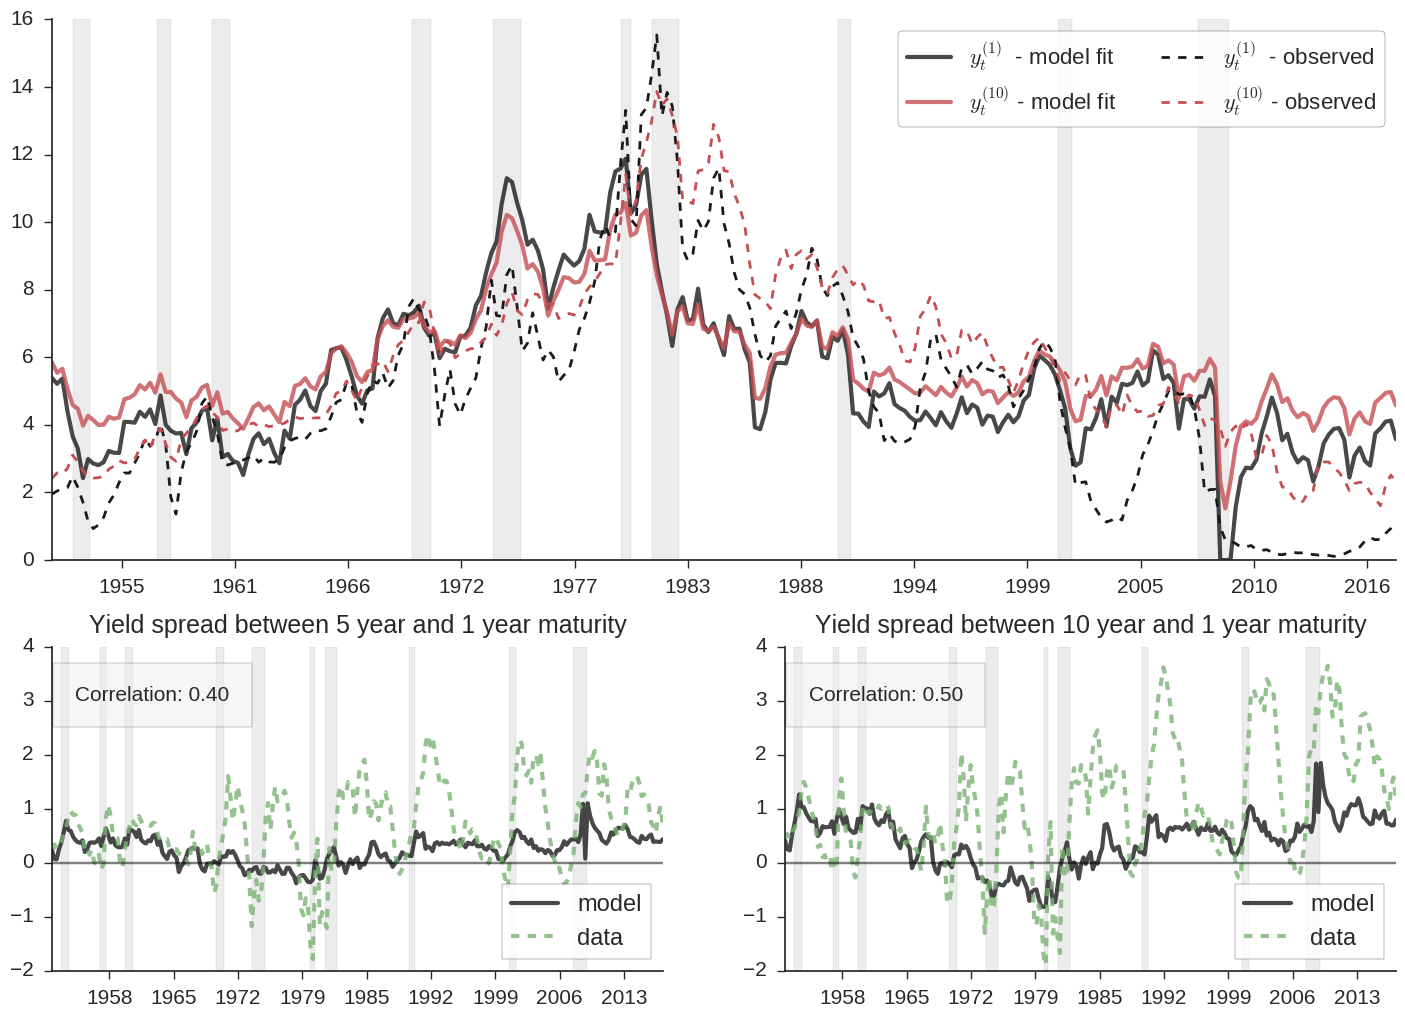

In [27]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = (14, 11))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1.8])
gs.update(bottom=0.035, left=0.035, top=.9, right=0.995)
ax = plt.subplot(gs[0, :])
sb.despine()

ax.plot(np.asarray(data.index), yield_hat[0,:], lw=3, color = '.1', alpha=.8)
ax.plot(np.asarray(data.index), yield_hat[3,:], lw=3, color = sb.color_palette()[2], alpha=.8)
ax.plot(np.asarray(data.index), np.asarray(data[['SVENY01']]), lw=2, linestyle = '--', 
        color = '.1')
ax.plot(np.asarray(data.index), np.asarray(data[['SVENY10']]), lw=2, linestyle = '--', 
        color = sb.color_palette()[2])
ax.set_ylim([0, 16])
ax.set_xlim([start_date, end_date])
ax.tick_params(axis='both', which='major', labelsize = 15)
ax.legend([r'$y^{(1)}_t$  - model fit', r'$y^{(10)}_t$ - model fit',
           r'$y^{(1)}_t$  - observed', r'$y^{(10)}_t$ - observed'], 
          loc = 'best', fontsize = 16, ncol = 2, fancybox = True, frameon=True, framealpha=0.8)
max_yticks = 15
xloc = plt.MaxNLocator(max_yticks)
ax.xaxis.set_major_locator(xloc)
NBER_Shade(ax, start_date, '../data/from_web/NBER_dates.txt')

#---------------------------------------
# Bottom figures
#---------------------------------------
max_yticks = 10
xloc = plt.MaxNLocator(max_yticks)

bx = plt.subplot(gs[1, 0])
sb.despine()
bx.plot(np.asarray(data.index), (yield_hat[1, :].T - yield_hat[0, :].T), 
        lw=3, label = 'model', color='.1', alpha=.8)
bx.plot(np.asarray(data.index), np.asarray(data['SVENY05'] - data['SVENY01']), 
        lw=3, linestyle = '--', label = 'data', color=sb.xkcd_rgb["faded green"], alpha=.8)
bx.axhline(0, color = 'k', alpha=.5)
bx.set_ylim([-2, 4])
bx.set_title('Yield spread between 5 year and 1 year maturity', fontsize = 18, y=1.02)
bx.text(np.asarray(data.index)[10], 3.0,  "Correlation: {:1.2f}".format(zx['model_5_1']['data_5_1']), 
        fontsize = 15, bbox={'facecolor':'#EEEEEE', 'alpha':0.5, 'pad':16} )
bx.set_xlim([start_date, end_date])
bx.legend(loc = 4, fontsize = 17, frameon=True, framealpha=0.8)
bx.tick_params(axis='both', which='major', labelsize = 15)
bx.xaxis.set_major_locator(xloc)
NBER_Shade(bx, start_date, '../data/from_web/NBER_dates.txt')

cx =  plt.subplot(gs[1, 1])
sb.despine()
cx.plot(np.asarray(data.index), (yield_hat[2, :].T - yield_hat[0, :].T), 
        lw=3, label = 'model', color='.1', alpha=.8)
cx.plot(np.asarray(data.index), np.asarray(data['SVENY10'] - data['SVENY01']), 
        lw=3, linestyle = '--', label = 'data', color=sb.xkcd_rgb["faded green"], alpha=.8)
cx.axhline(0, color = 'k', alpha=.5)
cx.set_ylim([-2, 4])
cx.set_title('Yield spread between 10 year and 1 year maturity', fontsize = 18, y=1.02)
cx.tick_params(axis='both', which='major', labelsize = 15)
cx.set_xlim([start_date, end_date])
cx.text(np.asarray(data.index)[10], 3.0,  "Correlation: {:1.2f}".format(zx['model_10_1']['data_10_1']), 
        fontsize = 15, bbox={'facecolor':'#EEEEEE', 'alpha':0.5, 'pad':16} )
cx.legend(loc = 4, fontsize = 17, frameon=True, framealpha=0.8)
cx.xaxis.set_major_locator(xloc)
NBER_Shade(cx, start_date, '../data/from_web/NBER_dates.txt')

if update_figures:
    plt.savefig("../figures/fig_4.pdf")

In [28]:
def yieldcurve(ax, x0, x3, x4, x5):
    year = 15
    ymin, ymax = 0, 10
    xnew = np.linspace(1e-10, year*4, num = 100)
    perc_wc = np.empty((3, len(xnew)))
    perc_wc_real = np.empty((3, len(xnew)))

    xi_0 = x0
    xi_1 = np.asarray([[0.0], [0.0]])
    xi_2 = np.asarray([[x3, 0.0], [x4, x5] ])
    
    ytm = np.arange(4, 61, 4)
    ave_yc = np.nanmean(np.asarray(data[gsw_plot]), 0)
    sd_yc = np.nanstd(np.asarray(data[gsw_plot]), 0)

    try:
        m1 = Robust(phi_est, kappa_est, sigma_est, beta0_est, beta1_est, alpha_est, xi_0, xi_1, xi_2, delta)
        for i in range(len(xnew)):
            perc_wc[0, i] = m1.yield_distribution(xnew[i], wcParam = 1, wcX = 0).mean()    
            stdev_wc = m1.yield_distribution(xnew[i], wcParam = 1, wcX = 0).std()  #ppf([.05, .95])
            perc_wc[1, i] = perc_wc[0, i] - stdev_wc 
            perc_wc[2, i] = perc_wc[0, i] + stdev_wc

            perc_wc_real[0, i] = m1.yield_distribution(xnew[i], wcParam = 1, wcX = 0, real = 1).mean()    
            stdev_wc_real = m1.yield_distribution(xnew[i], wcParam = 1, wcX = 0, real = 1).std()
            perc_wc_real[1, i] = perc_wc_real[0, i] - stdev_wc_real
            perc_wc_real[2, i] = perc_wc_real[0, i] + stdev_wc_real

        halflife = m1.chernoff()[0]
        ax.text(4, ymax-1.5, "Half-life = {:2.2f}  quarters".format(halflife), fontsize = 15,
                bbox={'facecolor':'#EEEEEE', 'alpha':0.5, 'pad':16} )
        
    except ValueError:
        for i in range(len(xnew)):
            perc_wc[0, i] = 0   
            perc_wc[1:,i] = np.zeros(2)
            perc_wc_real[0, i] = 0   
            perc_wc_real[1:, i] = np.zeros(2)
        ax.text(1.5*year, ymax-1.5, "Xi is not psd!", fontsize = 13,
                bbox={'facecolor':'#EEEEEE', 'alpha':0.9, 'pad':16} )
    ax.plot(xnew, perc_wc[0, :], lw = 3, color = 'DarkBlue', label = 'Mean (nominal)')
    ax.fill_between(xnew, perc_wc[1, :], perc_wc[2, :], color = "DarkBlue", alpha = .15)
    ax.plot(xnew, perc_wc_real[0, :], lw = 2, color = 'DarkRed', label = 'Mean (real)')
    ax.fill_between(xnew, perc_wc_real[1, :], perc_wc_real[2, :], color = "DarkRed", alpha = .15)

    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Yield to maturities (quarters)", fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize = 12)

    ax.plot(ytm, ave_yc, color = '.5', lw = 4, alpha = .9, label = 'Sample average')
    ax.plot(ytm, ave_yc - sd_yc, '--', lw=3, color = '#666699', alpha = .5, label = r'$\pm$ Sample std')
    ax.plot(ytm, ave_yc + sd_yc, '--', lw=3, color = '#666699', alpha = .5)


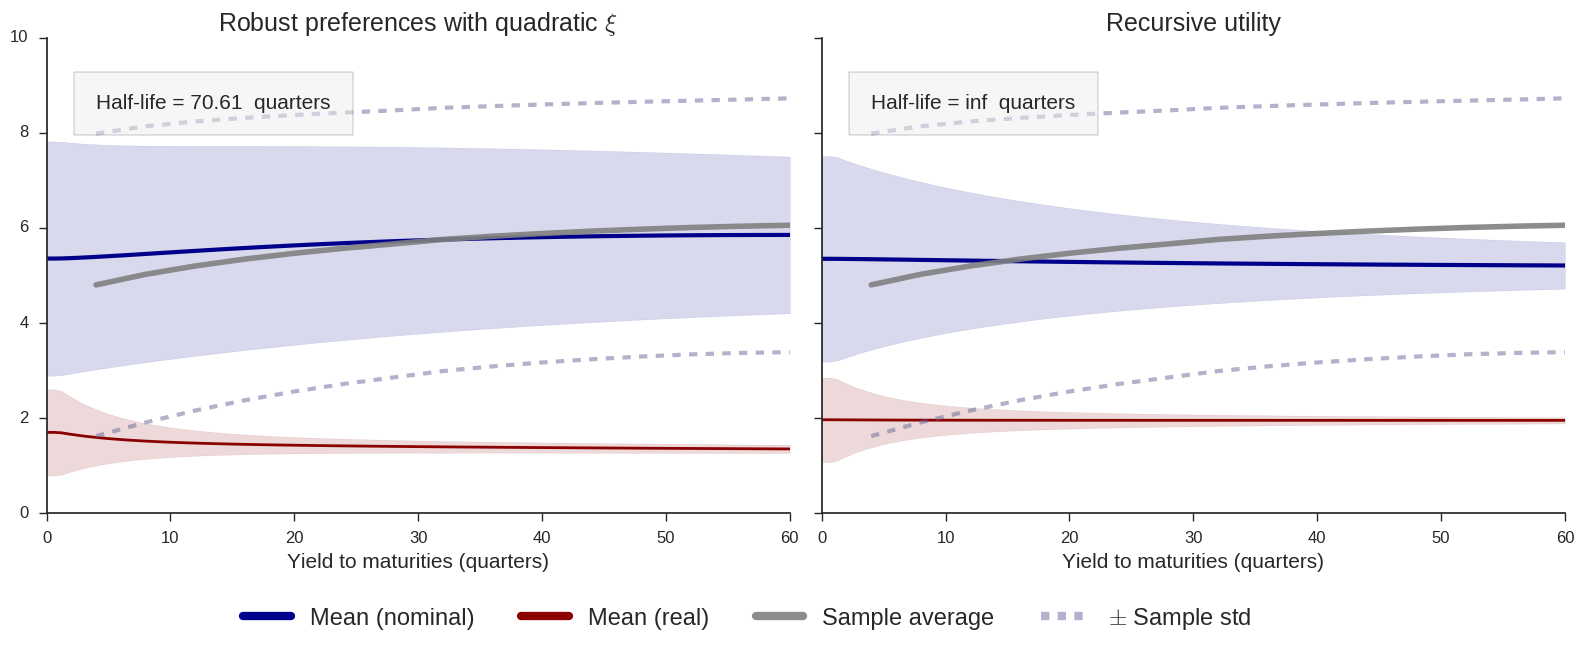

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6), sharey=True)
sb.despine()
yieldcurve(ax[0], param_xi[0], param_xi[3], param_xi[4], param_xi[5])
yieldcurve(ax[1], 0, 0, 0, 0)
lgd = plt.legend(loc = 'upper center', bbox_to_anchor=(-0.1, -0.15), fontsize = 17, ncol=5)
for legobj in lgd.legendHandles:
    legobj.set_linewidth(6)

ax[0].set_title(r'Robust preferences with quadratic $\xi$', fontsize = 18)
ax[1].set_title(r'Recursive utility', fontsize = 18)
plt.tight_layout()

if update_figures:
    plt.savefig("../figures/fig3.pdf")

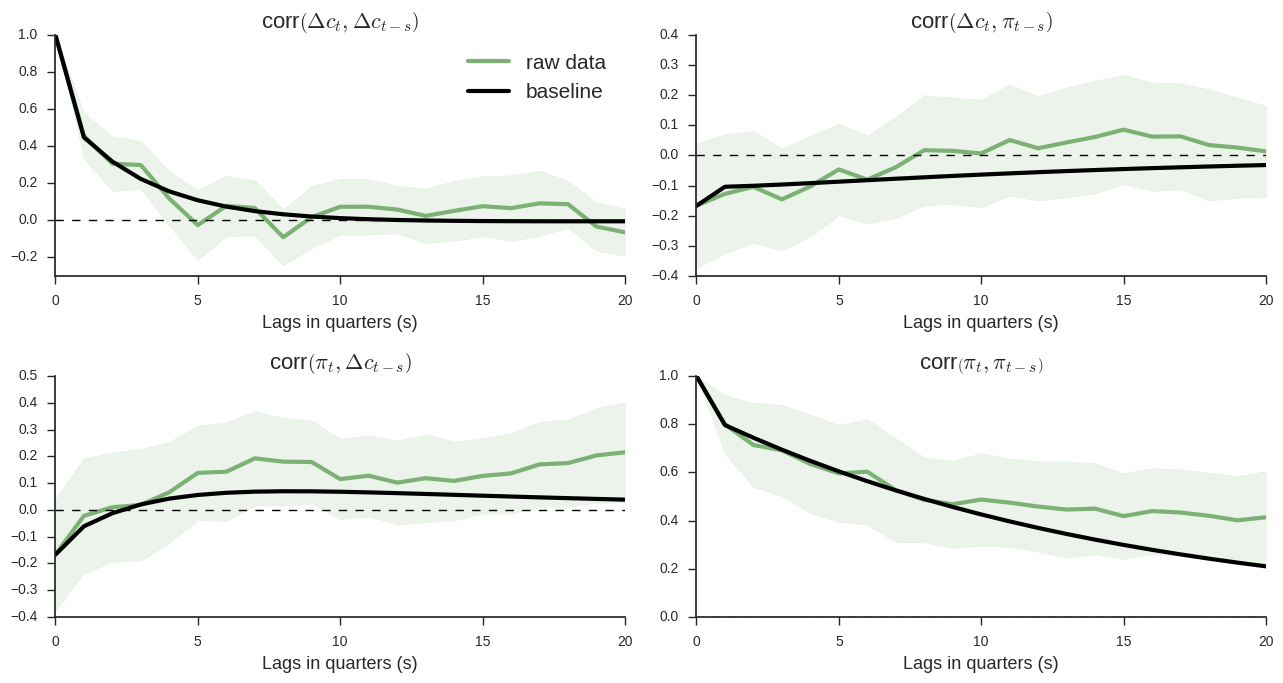

In [30]:
fig, ax = model2.autocorr_plot(data[aggregate_vars], 20, 4, [-1, 0], figsize = (13, 7))
sb.despine()
ax[0, 0].set_ylim([-.3, 1])
ax[0, 1].set_ylim([-.4, .4])
ax[1, 0].set_ylim([-.4, .5])
ax[1, 1].set_ylim([0, 1])
ax[0, 0].set_title(r'corr$\left(\Delta c_{t}, \Delta c_{t - s}\right)$', fontsize = 16)
ax[0, 1].set_title(r'corr$\left(\Delta c_{t}, \pi_{t - s}\right)$', fontsize = 16)
ax[1, 0].set_title(r'corr$\left(\pi_{t}, \Delta c_{t - s}\right)$', fontsize = 16)
ax[1, 1].set_title(r'corr$\left(\pi_{t}, \pi_{t - s}\right)$', fontsize = 16)
ax[0, 0].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[0, 1].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[1, 0].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[1, 1].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[0, 0].legend(['raw data', 'baseline'], loc='best', fontsize = 15) #, 'risk-neutral'

plt.tight_layout()

if update_figures:
    plt.savefig("../figures/fig_autocorr.pdf")

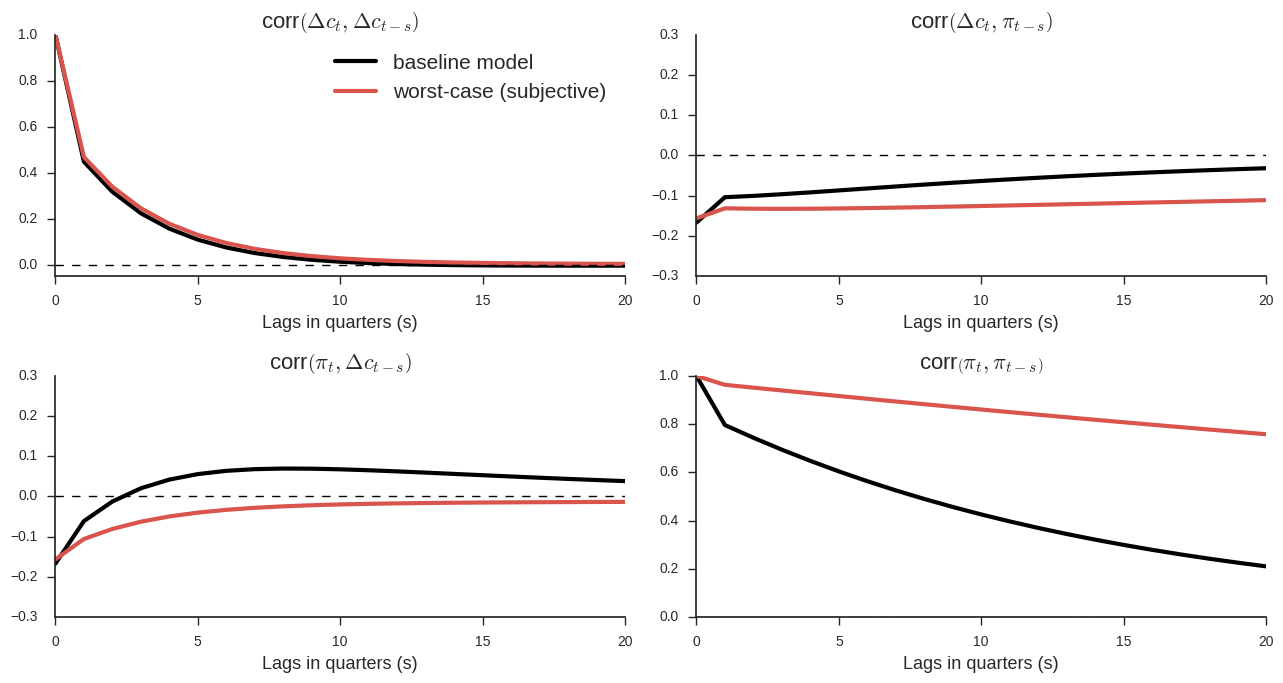

In [31]:
fig, ax = model2.autocorr_plot(data[aggregate_vars], 20, 4, [0, 1], figsize = (13, 7))
sb.despine()
ax[0, 0].set_ylim([-0.05, 1])
ax[0, 1].set_ylim([-.3, .3])
ax[1, 0].set_ylim([-.3, .3])
ax[1, 1].set_ylim([0, 1])
ax[0, 0].set_title(r'corr$\left(\Delta c_{t}, \Delta c_{t - s}\right)$', fontsize = 16)
ax[0, 1].set_title(r'corr$\left(\Delta c_{t}, \pi_{t - s}\right)$', fontsize = 16)
ax[1, 0].set_title(r'corr$\left(\pi_{t}, \Delta c_{t - s}\right)$', fontsize = 16)
ax[1, 1].set_title(r'corr$\left(\pi_{t}, \pi_{t - s}\right)$', fontsize = 16)
ax[0, 0].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[0, 1].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[1, 0].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[1, 1].set_xlabel(r'Lags in quarters (s)', fontsize = 13)
ax[0, 0].legend(['baseline model', 'worst-case (subjective)'], loc='best', fontsize = 15)

plt.tight_layout()
if update_figures:
    plt.savefig("../figures/fig_autocorr_2.pdf")

##  Model implied autocorrelation function for $y^{(4)}_t$ and $y^{(20)}_t$

In [32]:
Exx_obj = model2.from_cont_to_discrete(worstcase=0)[6]
Exx_subj = model2.from_cont_to_discrete(worstcase=1)[6]
kappa_D_tilde = np.eye(2) - model2.kappa_tilde

N_q = 8
maturities = [20, 40, 60]
horizons = np.arange(1, N_q + 1)
mat_len, hor_len = len(maturities), len(horizons)

yield_autocorr_obj = np.zeros((hor_len, mat_len))
yield_autocorr_subj = np.zeros((hor_len, mat_len))
spread_autocorr_obj = np.zeros(hor_len)
spread_autocorr_subj = np.zeros(hor_len)


for ind_j, jj in enumerate(maturities):
    b = model2.zero_coupon_yields(tau=jj, worstcase=1)[1:].reshape(2, 1)
    for ind_t, tt in enumerate(horizons):
        yield_autocorr_obj[ind_t, ind_j] = (b.T @ Exx_obj @ np.linalg.matrix_power(kappa_D, tt).T @ b)[0,0]/(b.T @ Exx_obj @ b)[0,0]
        yield_autocorr_subj[ind_t, ind_j] = (b.T @ Exx_subj @ np.linalg.matrix_power(kappa_D_tilde, tt).T @ b)[0,0]/(b.T @ Exx_subj @ b)[0,0]

db = model2.zero_coupon_yields(tau=20, worstcase=1)[1:].reshape(2, 1) - model2.zero_coupon_yields(tau=4, worstcase=1)[1:].reshape(2, 1)

for ind_t, tt in enumerate(horizons):
    spread_autocorr_obj[ind_t] = (db.T @ Exx_obj @ np.linalg.matrix_power(kappa_D, tt).T @ db)[0,0]/(db.T @ Exx_obj @ db)[0,0]
    spread_autocorr_subj[ind_t] = (db.T @ Exx_subj @ np.linalg.matrix_power(kappa_D_tilde, tt).T @ db)[0,0]/(db.T @ Exx_subj @ db)[0,0]

yield_autocorr_data = np.zeros((hor_len, 1+len(YTM['nominal'])))
spread_autocorr_data = np.zeros(hor_len)

for ind_j, var in enumerate(gsw_vars[:-2]):
    for ind_t, t in enumerate(horizons): 
        yield_autocorr_data[ind_t, ind_j] = pd.Series.autocorr(data[var], t)
        spread_autocorr_data[ind_t] = pd.Series.autocorr(data['SVENY05']-data['SVENY01'], t)

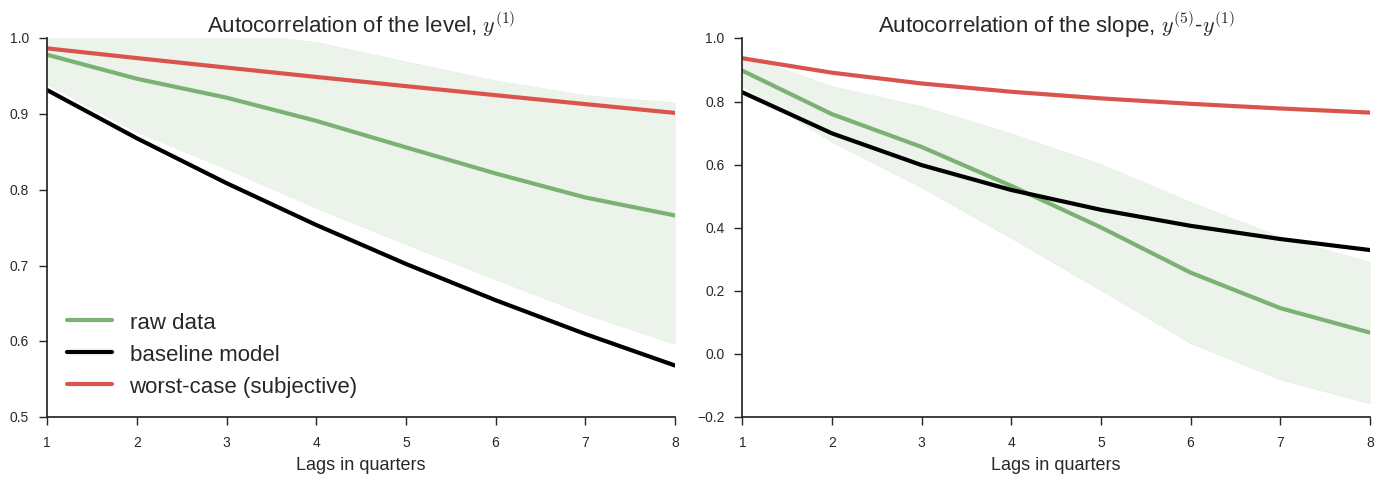

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
sb.despine()
dd = pd.DataFrame(data = pd.concat([data['SVENY01'], data['SVENY05']-data['SVENY01']], axis=1))
LB, UB = autocorrelation(dd, nn = N_q, NW_lags=4)[1:]

ax[0].set_title(r'Autocorrelation of the level, $y^{(1)}$', fontsize = 16)
ax[0].plot(np.arange(1, N_q + 1), yield_autocorr_data[:, 0], lw = 3, 
           color = sb.xkcd_rgb["faded green"], label = 'raw data')
ax[0].fill_between(np.arange(1, N_q + 1), LB[1:, 0], UB[1:, 0], 
                   color = sb.xkcd_rgb["faded green"], alpha = .15)
ax[0].plot(np.arange(1, N_q + 1), yield_autocorr_obj[:, 1], lw = 3, 
           color = 'k', label = "baseline model")
ax[0].plot(np.arange(1, N_q + 1), yield_autocorr_subj[:, 1], lw = 3, 
           color = sb.xkcd_rgb['pale red'], label = 'worst-case (subjective)')
ax[0].set_ylim([.5, 1])
ax[0].set_xlabel('Lags in quarters', fontsize = 13)
ax[0].legend(loc = 'best', fontsize = 16)


ax[1].set_title(r'Autocorrelation of the slope, $y^{(5)}$-$y^{(1)}$', fontsize = 16)
ax[1].plot(np.arange(1, N_q + 1), spread_autocorr_data[:N_q], lw = 3, 
           color = sb.xkcd_rgb["faded green"], label = 'raw data')
ax[1].fill_between(np.arange(1, N_q + 1), LB[1:, 3], UB[1:, 3], 
                   color = sb.xkcd_rgb["faded green"], alpha = .15)
ax[1].plot(np.arange(1, N_q + 1), spread_autocorr_obj[:N_q], lw = 3, 
           color = 'k', label = 'objective')
ax[1].plot(np.arange(1, N_q + 1), spread_autocorr_subj[:N_q], lw = 3, 
           color = sb.xkcd_rgb['pale red'], label = 'subjective')
ax[1].set_xlabel('Lags in quarters', fontsize = 13)

plt.tight_layout()

if update_figures:
    plt.savefig('../figures/yield_autocorr.pdf')

-------------------------------------------------------------
# Create DataFrame containing model generated counterparts of survey data

First we save the model's defining matrices in an `.npz` file so that we can load it simply in other notebooks. The numpy method is `np.savez`  

In [34]:
np.savez('model', model2.phi, model2.kappa, model2.sigma, 
                  model2.beta0, model2.beta1, model2.alpha, 
                  model2.xi_0, model2.xi_1, model2.xi_2, 
                  model2.delta, 
                  kwds=('phi', 'kappa', 'sigma', 'beta0', 'beta1', 'alpha', 
                        'xi_0', 'xi_1', 'xi_2', 'delta'))

Then generate model implied
 * zero-coupon yields with maturities from 0.5y to 30.0y
 * subjective forecasts about $h$ quarter ahead interest rates (h is from 1q to 5q)
 * objective forecasts about $h$ quarter ahead interest rates (h is from 1q to 5q) = $a$ and $b$ coefficients of yields come from the worst-case model, but the state dynamics follows the baseline law of motion 

In [35]:
maturities = np.arange(2, 121, 2)

#-----------------------------------------------------------
# Generate model implied yields for all maturities
#-----------------------------------------------------------
yield_coeffs = model2.zero_coupon_yields(maturities, worstcase = 1).T 
Xhat = np.ones((3, X_hat.shape[0]))
Xhat[1:,:] = X_hat.T
yield_hat = yield_coeffs @ Xhat            # Obs x T matrix containing the model implied yields


model_data = pd.DataFrame(data = np.hstack([Xhat.T, yield_hat.T]), 
                          index=data.index, 
                          columns=['ones', 'Edc', 'Epi'] + [str(i) + 'y' for i in np.arange(1, 61)/2])

#-----------------------------------------------------------
# Generate model implied expectations about future yields 
#-----------------------------------------------------------
#Xhat_survey = model_data[['ones', 'Edc', 'Epi']]['1982-12':].values

model_expectations = pd.DataFrame(index=model_data.index)
for horizon in range(1, 6):
    d = (model2.yield_forecast_ab(maturities, tau_end=horizon, worstcase=1) @ Xhat).T
    dd = pd.DataFrame(data=d,
                      columns=[str(i) + 'y_' + str(horizon) + 'q' for i in np.arange(1, 61)/2],
                      index=model_data.index)
    model_expectations = pd.concat([model_expectations, dd], axis=1) 

# Objective expectations about future yields 
for horizon in range(1, 6):
    d = (model2.yield_forecast_ab(maturities, tau_end=horizon, worstcase=0) @ Xhat).T
    dd = pd.DataFrame(data=d,
                      columns=[str(i) + 'y_' + str(horizon) + 'q_obj' for i in np.arange(1, 61)/2],
                      index=model_data.index)
    model_expectations = pd.concat([model_expectations, dd], axis=1) 

model_data = pd.concat([model_data, model_expectations], axis=1)

In [36]:
#-----------------------------------------------------------------------
# Calculate the path of subjective forecast error and bias in the model 
#-----------------------------------------------------------------------
list_of_yields = [str(i) + 'y'  for i in np.arange(1, 61)/2]
horizons = ['_1q', '_2q', '_3q', '_4q', '_5q'] 

forecast_error = pd.DataFrame(index=model_data.index)

for i, ytm in enumerate(list_of_yields):
    for t, hor in enumerate(horizons):
        d = np.vstack([model_data[ytm].iloc[(t+1):],
                       model_data[ytm + hor].iloc[:-(t+1)].values - 
                       model_data[ytm].iloc[(t+1):].values]).T
        dd = pd.DataFrame(data=d,
                      columns=[ytm + '_tp' + str(t+1), ytm + hor + '_err'],
                      index=model_data.index[:-(t+1)])
        forecast_error = pd.concat([forecast_error, dd], axis=1)
        
model_data = pd.concat([model_data, forecast_error], axis=1)

model_data.to_csv('../data/data_model.csv', sep = ',')

-------------------------------
# Standard Errors

In [37]:
from statsmodels.tools.numdiff import approx_fprime as Jacobian
from statsmodels.tools.numdiff import approx_hess as Hessian

params_est = np.hstack([result_step1.x, res_step2_case1.x])
#params_est = np.hstack([result_step1.x, np.asarray([100, -20, 1105])])
yield_data = data[gsw_vars]
T, m = yield_data.shape

# difference between the fitted and the realized yields
yield_diff = yield_hat.T - yield_data

# Introduce some notation: 
m_1, m_2 = len(YTM['nominal']), len(YTM['real'])
if m_1 + m_2 != m:
    raise ValueError("Number of observations is not consistent with YTM and YTM_R vectors")

k = len(params_est)
k_1, k_2 = 11, 4

Tm = T*m - np.sum(np.isnan(np.asarray(data[gsw_vars])))

ValueError: operands could not be broadcast together with shapes (261,60) (261,6) 

#### Calculating the score

In [88]:
def loglh_func(params):
    llh = kalman_filter(params[:k_1], data[aggregate_vars], model = 'restricted_3')[2]
    return -llh

In [89]:
score = Jacobian(params_est, loglh_func)
score = score.squeeze()[:, :k_1]
print(np.mean(score, 0))
print(result_step1.jac)

[ -6.77366827e-07  -7.95233966e-07   6.20045808e-08   3.19748016e-07
   4.28577419e-08  -1.09657818e-06   6.82482568e-07   1.38051798e-06
  -2.30245838e-07  -7.42531215e-08  -6.01571578e-07]
[ -6.70552254e-07  -7.52508640e-07   8.19563866e-08   3.20374966e-07
   1.04308128e-07  -1.02818012e-06   7.67409801e-07   1.44541264e-06
  -1.63912773e-07  -1.49011612e-08  -5.21540642e-07]


##### Calculation of $g_2(\widehat{\theta}, \widehat{\xi})$

In [90]:
beta0 = data[aggregate_vars].mean(0).reshape(2, 1)/100

In [92]:
def obj_func(params):
        
    phi, kappa, sigma, b0, beta1, alpha = extract_params(params[:k_1], model = 'restricted_3')
    X_hat = kalman_filter(params[:k_1], data[aggregate_vars], model = 'restricted_3')[1].T
    phi = phi/100
    sigma = sigma/100
    alpha = alpha/100
    X_hat = X_hat/100
    
    phi, kappa, sigma, beta_0, beta1, alpha = from_discrete_to_cont(phi, kappa, sigma, beta0, beta1, alpha)
    param_mle = build_params(phi, kappa, sigma, beta_0, beta1, alpha)

    ssq_e = second_step_estimation(params[k_1:], param_mle, X_hat, 
                                       data[gsw_vars], ytm = YTM, case = 1,
                                       delta = delta)[0]/10**2
    g_2 = second_step_estimation(params[k_1:], param_mle, X_hat, 
                                       data[gsw_vars], ytm = YTM, case = 1,
                                       delta = delta)[1]        
    return ssq_e, g_2

In [93]:
Jacobian(params_est, lambda x: obj_func(x)[0])

array([  1.12785162e+00,  -1.61308616e+00,   1.51782517e+00,
        -7.60212376e-01,   1.83778377e+00,   3.35521877e+00,
         2.21798807e+00,   5.60488840e+00,  -7.13483876e-01,
        -1.04419827e+00,  -2.05120867e+00,   4.49073315e-01,
         6.55234010e-06,  -3.33739448e-06,   6.16309190e-05])

In [94]:
g_2_store = Jacobian(params_est, lambda x: obj_func(x)[1])
g_2 = np.zeros((k_2, T))

for i in range(k_2):
    g_2[i, :] = np.nansum(g_2_store[:, :, k_1 + i].T, 1)/(Tm/T)

#check
print(np.sum(g_2, 1)/T)

[  4.49073280e-01   6.55240709e-06  -3.33736332e-06   6.16309832e-05]


In [95]:
res_step2_case1.jac[:-1]/10**2

array([  4.49082642e-01,   8.65936279e-06,  -6.63757324e-06,
         6.01959229e-05])

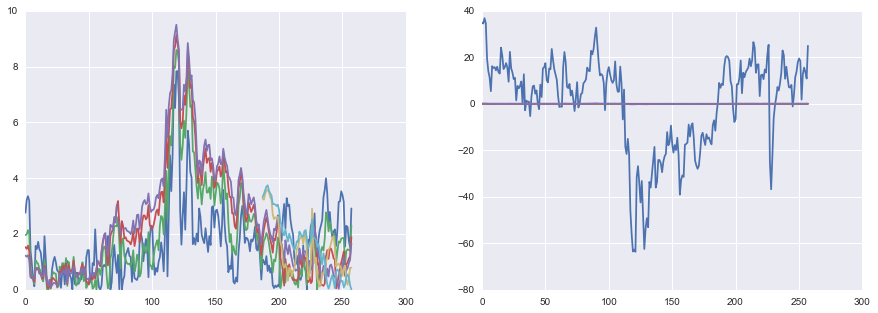

In [96]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(np.sqrt(second_step_estimation(params_est[k_2:], param_est_cont, X_hat, data[gsw_vars], 
                                          YTM, 1, delta)[1]))
ax[1].plot(g_2.T)

In [97]:
def S_matrix(data, NW_lags):
    
    T, M = data.shape
    data = np.asarray(data - data.mean(0))

    S = (data.T @ data)/T
        
    for j in range(1, NW_lags):
        S_temp = (data[j:, :].T @ data[:-j, :])/T
        S += 2 * (1 - j/NW_lags) * S_temp
    
    return S

In [98]:
# Construction of V
gg = np.vstack([score.T, g_2]).T
cov_g1g2 = S_matrix(gg, 4)
V_11 = la.inv(result_step1.hess_inv)
V_21 = cov_g1g2[k_1:, :k_1]
V_22 = cov_g1g2[k_1:, k_1:]
V = np.vstack([np.hstack([V_11, V_21.T]), np.hstack([V_21, V_22])])

In [99]:
GG = Hessian(params_est, lambda x: obj_func(x)[0])

In [100]:
G_11_inv = result_step1.hess_inv
G_22_inv =  np.linalg.inv(GG[k_1:, k_1:])
G_21 = GG[k_1:, :k_1]
G_inv = np.vstack([np.hstack([G_11_inv, np.zeros((k_1, k_2))]),
                   np.hstack([ - G_22_inv @ G_21 @ G_11_inv, G_22_inv])])

In [101]:
xi_est = res_step2_case3.x
xi_est_cov = (G_inv @ V @ G_inv.T)/T

In [102]:
xi_se = np.sqrt(np.diag(xi_est_cov[k_1:, k_1:])/100)
print(xi_se)

[  4.12782946e-02   4.08758616e+03   3.81651583e+02   1.83072515e+02]


In [88]:
print(np.asarray([model2.xi_2[0, 0], model2.xi_2[1, 0], model2.xi_2[1,1]]))
print(np.sqrt(np.diag(xi_est_cov[k_1:, k_1:])))

[ 1474.81 -1291.51  1130.99]
[  5.01e-01   6.83e+04   4.27e+03   1.84e+03]


In [79]:
np.sqrt(np.diag(xi_est_cov[:k_1, :k_1]))

array([ 0.09,  0.03,  0.07,  0.03,  0.03,  0.03,  0.02,  0.03,  0.02,
        0.02,  0.02])

In [65]:
##=================================================
## Generate latex table
##=================================================

def format_table(x):
    if type(x) == float:
        return '{0:.1f}'.format(x)
    if type(x) == str:
        return '{0:.5s}'.format(x)

def format_table_par(x):
    if type(x) == float:
        return '({0:.1f})'.format(x)
    if type(x) == str:
        return '{0:.5s}'.format(x)


xi_coeffs = np.hstack([res_step2_case1.x[0], 1, res_step2_case1.x[1:]])
xi_se2 = np.hstack([xi_se[0], 1, xi_se[1:]])
table2 = np.vstack([xi_coeffs, xi_se2]) 

table2 = np.asarray(table2, dtype='object')

table2[:, 1] = np.asarray(["", ""])

print(" \\\\\n".join([" & ".join(map(format_table, table2[0, :]))]) + "  \\rule[2.4ex]{0pt}{0pt}  \\\\\n" +
      " \\\\\n".join([" & ".join(map(format_table_par, table2[1, :]))]) + "\\\\\n")

0.0 &  & 605.5 & -825.3 & 1125.0  \rule[2.4ex]{0pt}{0pt}  \\
(0.0) &  & (4086.6) & (380.0) & (182.0)\\

